In [6]:
%load_ext autoreload
%autoreload 2

# Load experiment_groups from disk
import dill
from disruption_survival_analysis.sweep_config import get_experiments, create_experiment_groups

#device = 'synthetic'
#dataset_path = 'test'
devices = ['cmod']
#dataset_paths = ['preliminary_dataset_no_ufo']
#dataset = 'sql_all_no_ufo'
dataset='sql_match'
dataset_paths = [f"{dataset}/stack_10"]

# models, alarms, metrics, and minimum warning times to use
models = ['cph']
#models = ['rf']
alarms = ['sthr']
metrics = ['auroc']
min_warning_times = [0.01]

experiment_groups = create_experiment_groups(devices, dataset_paths, models, alarms, metrics, min_warning_times)



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
---
Attempting to load hyperparameters from yaml file...
Loaded hyperparameters for cmod/sql_match/stack_10/configs/cph_sthr_auroc_10ms.yaml
---
Loaded model from models/cmod/sql_match/stack_10/cph_sthr_auroc_10ms.pkl


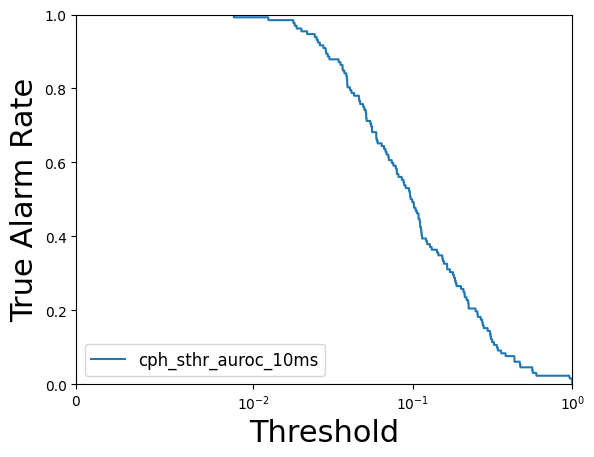

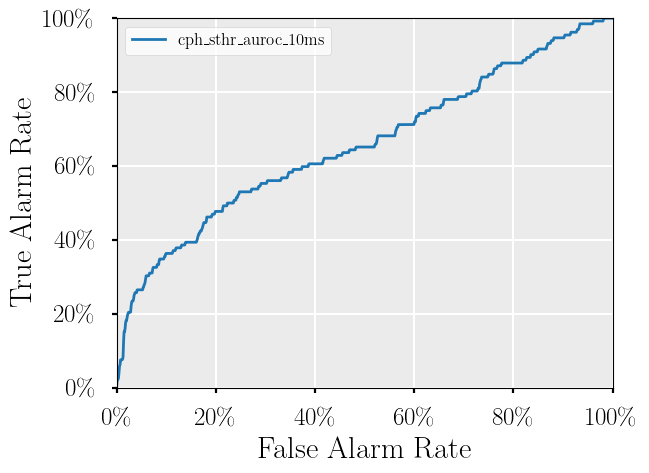

In [7]:
from disruption_survival_analysis.plot_experiments import plot_true_alarm_rates_vs_thresholds, plot_false_alarm_rates_vs_thresholds, plot_warning_times_vs_thresholds
from disruption_survival_analysis.plot_experiments import plot_true_alarm_rates_vs_false_alarm_rates, plot_missed_alarm_rates_vs_false_alarm_rates, plot_avg_warning_times_vs_false_alarm_rates

experiment_list = get_experiments(experiment_groups, ['auroc'])
plot_true_alarm_rates_vs_thresholds(experiment_list)
plot_true_alarm_rates_vs_false_alarm_rates(experiment_list)

In [8]:
#with open(f"experiment_groups_{dataset}.pkl", 'wb') as f:
#    dill.dump(experiment_groups, f)

with open(f"experiment_groups_bootstrap.pkl", 'rb') as f:
    experiment_groups = dill.load(f)

In [21]:
from disruption_survival_analysis.Experiments import Experiment

num_bootstraps = 100

required_warning_time = 0.01

dataset_path = dataset_paths[0]

experiment_list = get_experiments(experiment_groups, [dataset_path, 'cph', 'auroc', required_warning_time])

tars_list = []
fars_list = []

for experiment in experiment_list:
    for i in range(num_bootstraps):
        fars, tars, _, _ = experiment.get_critical_metrics_vs_false_alarm_rates(bootstrap_seed=i)
        tars_list.append(tars)
        fars_list.append(fars)



In [22]:
import numpy as np
# Find all the unique false alarm rates and sort them
unique_fars = np.unique(np.concatenate(fars_list))
unique_fars.sort()

# Interpolate the true alarm rates for each bootstrap at the unique false alarm rates
interp_tars_list = []
for i, tars in enumerate(tars_list):
    interp_tars_list.append(np.interp(unique_fars, fars_list[i], tars_list[i]))

# Compute the mean, upper quartile, and lower quartile true alarm rates at each unique false alarm rate
mean_tars = np.mean(interp_tars_list, axis=0)
upper_tars = np.percentile(interp_tars_list, 75, axis=0)
lower_tars = np.percentile(interp_tars_list, 25, axis=0)
max = np.max(interp_tars_list, axis=0)
min = np.min(interp_tars_list, axis=0)

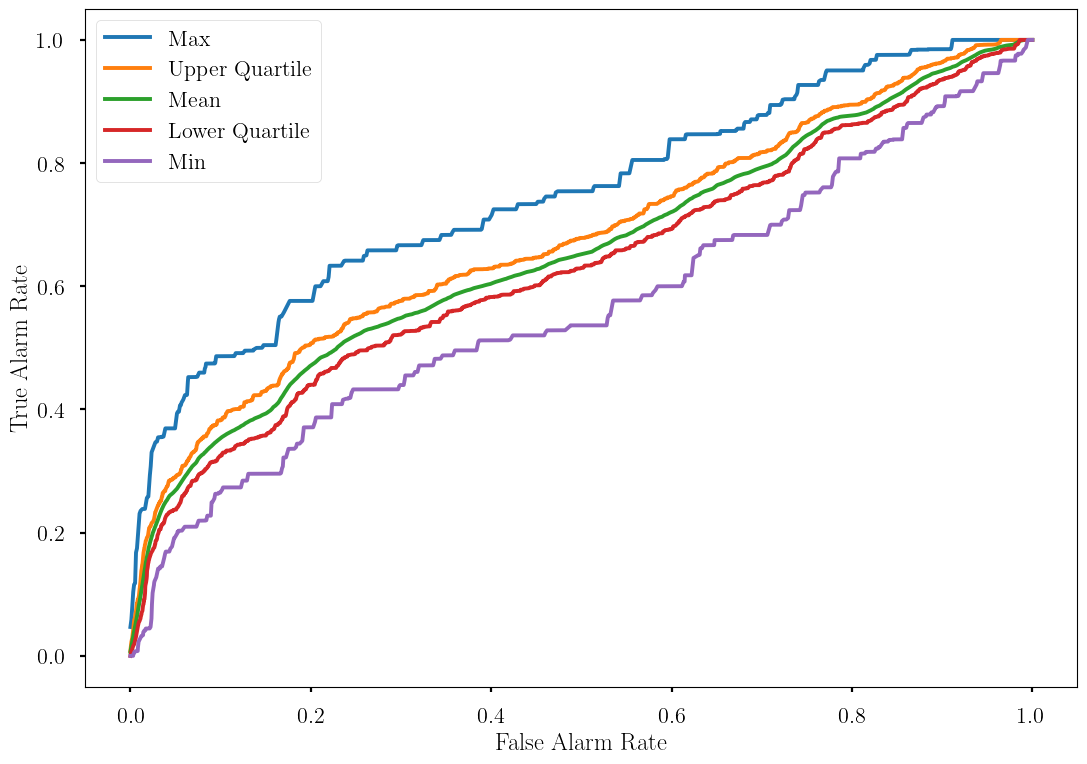

In [23]:
# Plot the mean true alarm rates with the upper and lower quartiles
import matplotlib.pyplot as plt

plt.plot(unique_fars, max, label='Max')
plt.plot(unique_fars, upper_tars, label='Upper Quartile')
plt.plot(unique_fars, mean_tars, label='Mean')
plt.plot(unique_fars, lower_tars, label='Lower Quartile')
plt.plot(unique_fars, min, label='Min')

plt.xlabel('False Alarm Rate')
plt.ylabel('True Alarm Rate')

plt.legend()

plt.show()

